# **NANOINDENTATION DATA POST-PROCESSING**
---
### De Cet Anna
Python Driving License - June 2023

## Step 1: Setup and Data Loading

We will work on .txt files containing data that we obtain from the Nanoindenter machine, which is stored in a Google Drive folder. \\
First, we need to mount the content of the folder to the Google Colab drive.

In [ ]:
# first we link our google drive to Google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then, we import all the libraries that will be used in the notebook. \\
This list has been updated progressively alongside the code-writing process.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro

We need to reach the directory containing the data; to make sure the folder is the correct one, we list its contents.

In [ ]:
%cd drive/MyDrive/NanoHAP/
%ls

/content/drive/MyDrive/NanoHAP
Curve-Berk100mN-beam5.txt  Curve-Berk50mN-beam5.txt     Results-Berk200mN-beam5.txt
Curve-Berk10mN-beam5.txt   Results-Berk100mN-beam5.txt  Results-Berk50mN-beam5.txt
Curve-Berk200mN-beam5.txt  Results-Berk10mN-beam5.txt


The nanoindentation data is composed of:
* "Results", the data processed by the machine. This is a table composed of as many rows as the number of indentations performed, and 12 columns corresponding to different parameters. \\
We will need, in particular:
  * The reduced elastic modulus E [GPa]; used to calculate the indented material's elastic modulus
  * The hardness H [GPa]
  * The maximum depth d [nm]
* "Curves", the force-displacement data recorded by the machine for each indentation, one after the other. This is a table composed of three columns: one for the force values, one for the displacement values and one for the time. The start of each new indentation will coincide with time = 0. \\

Each nanoindentation process is usually carried out in our lab with four different loads: 10 mN, 50 mN, 100 mN, 200 mN.

In [ ]:
# the file name for the result data is always Results-Berk[load]mN-beam5.txt
# the file name for the curves data is always Curve-Berk[load]mN-beam5.txt
results_basename = 'Results-Berk'
curve_basename = 'Curve-Berk'
beam = 'mN-beam5.txt'

# we list the possible loads
load = [10, 50, 100, 200]

# the following three variables will be needed to calculate the Material Elastic Modulus
Eind = 1141;
nuind = 0.07;
nu = 0.3; # <- this is an assumption, though it should not impact the material modulus too significantly

In [ ]:
def estrai_file_risultati(i):
  '''
  Function to extract the results of the nanoindentation
  INPUT = i, index used to call upon the possible loads used during the experiment
  OUTPUT = dataframe of four columns, containing the values of E (reduced and 'real'), H and max_depth
  '''
  filename_result = results_basename + str(load[i]) + beam
  resi = np.loadtxt(filename_result, skiprows = 3) # the first three rows are skipped due to the default .txt file header
  results = pd.DataFrame({'Reduced Elastic Modulus [GPa]': resi[:,6],
                        'Material Hardness [GPa]': resi[:,5],
                        'Maximum Depth [nm]': resi[:,3]})

  # the following function is needed to calculate the material elastic modulus based on the reduced modulus and indenter parameter
  elm = (1-nu**2) * ( (1/resi[:,6]) - ( (1-nuind**2)/Eind ) )**(-1)

  results.insert(3,'Material Elastic Modulus [GPa]', elm[:])
  # a dataframe has been chosen for easiness of use and to be able to assign names to the variables
  return results

In [ ]:
# Import the Results data

for i in range(4):
  result = estrai_file_risultati(i) # call the function to obtain the dataframe
  varname = "results_" + str(load[i]) # set the new name for the variable as results_carico
  locals()[varname] = result # update the variable name

In the following block, we set up the function required to extract all the curves relative to one specific loading condition.
\
Further elaboration will be carried out in Step 3 - Pop-in detection.

In [ ]:
def estrai_file_curve(i):
  '''
  Function to extract the load/displacement curves of the nanoindentations
  INPUT = i, index used to call upon the possible loads used during the experiment
  OUTPUT = dataframe of three columns, containing the values of depth, load and time recorded

  every new indentation of each set begins at time 0
  '''
  filename_curve = curve_basename + str(load[i]) + beam
  curvi = np.loadtxt(filename_curve)
  curveAll = pd.DataFrame({'Load [mN]': curvi[:,0],
                        'Depth [nm]': curvi[:,1],
                        'Time [s]': curvi[:,2]})
  return curveAll

## Step 2: Statistical Analysis

In this section, we want to check if there are outliers, each group's mean and standard deviation, our data distribution, and finally define if the results we obtained are comparable within different groups.

### 2.1: Outlier Detection

In order to define outliers, we choose to analise the elastic modulus and hardness of the material being indented.
Since it is the same material for all the indentations, we would expect to always find comparable values.

There are different ways we can find outliers inside a given dataset; for this analysis, we will focus on two: one mathematical and one visual.

First, we evaluate the Z-score (or standard score) to define how distant a specific datapoint is from the mean. \\
Then, we visualize the dataset boxplot, highlighting the values that were found to have a Z-score higher than a certain threshold.

We also add a new column to our dataframe, to keep track of which indentation results were flagged as outliers; later we will check if the curves corresponding to those indentations are characterized by pop-in phenomenons.

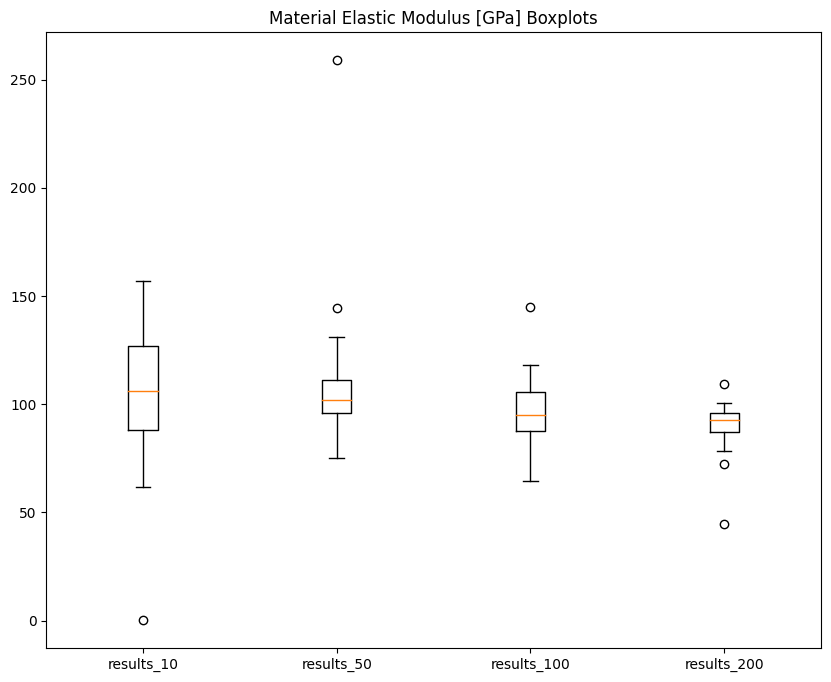

In [ ]:
n = 3; # this corresponds to choosing to perform our analysis on the material elastic modulus

# we initialize a plot, so we will be able to see all the boxplots highlighting the outliers

fig = plt.subplots(1,1,figsize=[10,8])
ax = plt.subplot(111)
tick_labels = []

for i in range(4):

  varname = "results_" + str(load[i])
  tick_labels.append(varname)
  temp = locals()[varname]
  z = np.abs(stats.zscore(temp.iloc[:,n]))

  threshold = 1
  outliers = temp[z > threshold]

  # we want to plot all the boxplots in the same plot, so that they share the vertical scalebar
  ax.boxplot(temp.iloc[:,n],positions=[i])

  idx = outliers.index.tolist()

  # as we have defined outliers, we mark down what indentations outputted outlier values
  # this will be used later when we will compare these outliers with those detected through pop-ins
  locals()[varname].insert(4,'Outliers?','No')
  locals()[varname].loc[idx, 'Outliers?'] = 'Yes'

plt.title("Material Elastic Modulus [GPa] Boxplots")
ax.set_xticklabels(tick_labels)
plt.show()

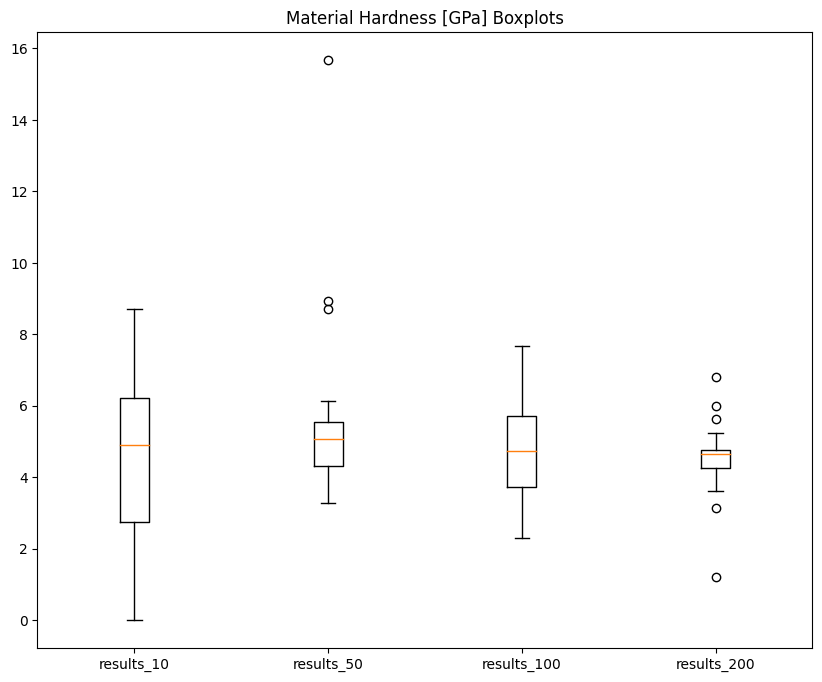

In [ ]:
n = 1; # this corresponds to choosing to perform our analysis on the material elastic modulus

# we initialize a plot, so we will be able to see all the boxplots highlighting the outliers

fig = plt.subplots(1,1,figsize=[10,8])
ax = plt.subplot(111)
tick_labels = []

for i in range(4):
  #plt.sca(axes[i])
  varname = "results_" + str(load[i])
  tick_labels.append(varname)
  temp = locals()[varname]
  z = np.abs(stats.zscore(temp.iloc[:,n]))

  threshold = 1
  outliers = temp[z > threshold]

  ax.boxplot(temp.iloc[:,n],positions=[i])

  idx = outliers.index.tolist()

  # here, we already have created the outliers column, and some rows have already been marked down
  # our objective is therefore to update the selection of outliers
  for k in range(len(idx)):
    if locals()[varname].loc[idx[k], 'Outliers?'] == 'No':
      locals()[varname].loc[idx[k], 'Outliers?'] = 'Yes'

plt.title("Material Hardness [GPa] Boxplots")
ax.set_xticklabels(tick_labels)
plt.show()

### 2.2: Data Distribution & Describing Values

We want to check the normality of our datasets, which will influence how we describe and analyse our data in further steps.

Since we generally have 25 indentations, therefore 25 different values, we use the Shapiro-Wilk test to check data normality.

Once we have eliminated our outliers and defined data normality, we can define some describing values for our obtained parameters.

If our distributions are normal, then we can calculate averages and standard deviations; if our distributions are not normal, we evaluate medians and interquartile ranges.

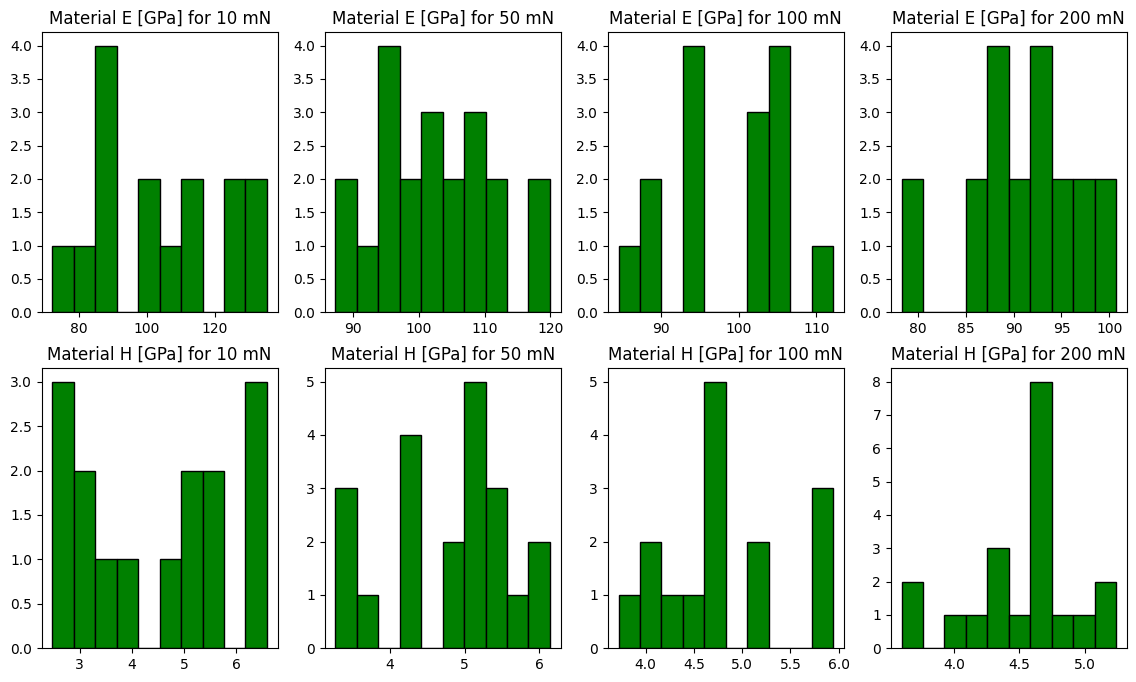

In [ ]:
all_loads = pd.DataFrame([])

fig, axes = plt.subplots(2,4,figsize=[14,8])
axes = axes.flatten()

for i in range(4):

  varname = "results_" + str(load[i])
  temp = locals()[varname]
  temp_filtered = temp.loc[temp['Outliers?'] == 'No']
  # we only consider the rows of indentations that are not marked as outliers

  plt.sca(axes[i])
  n = 3;
  shap = shapiro(temp_filtered.iloc[:,n])

  # the assumed "norm" is a normal data distribution
  nonnorm = "green"
  check = "Yes"
  summary_value = temp_filtered.iloc[:,n].mean()
  deviation = temp_filtered.iloc[:,n].std()

  if shap[1] < 0.05:
    # if the pvalue is smaller than 0.05 we can reject the null hypothesis
    # therefore we have evidence that the distribution is not normal
    # we will color the corresponding histograms in red
    # and calculate medians and interquartile ranges
    nonnorm = "red"
    check = "No"
    summary_value = temp_filtered.iloc[:,n].median()
    quartiles = temp_filtered.iloc[:,n].quantile([0.25, 0.75])
    deviation = quartiles[0.75] - quartiles[0.25]

  # we store the values obtained for the Elastic Modulus inside a temporary dataframe
  temporaryE = pd.DataFrame({"Indentation Load": str(load[i]),
                          "E Normal?": check,
                          "E Normality Pvalue" : shap[1],
                          "E Mean / Median" : summary_value,
                          "E StDev / IntRg" : deviation}, index = [0])

  plt.hist(temp_filtered.iloc[:,n], color = nonnorm, ec="black")
  plt.title("Material E [GPa] for " + str(load[i]) + " mN")

  # now starts the section relative to the hardness
  plt.sca(axes[i+4])
  n = 1;
  shap = shapiro(temp_filtered.iloc[:,n])


  nonnorm = "green"
  check = "Yes"
  summary_value = temp_filtered.iloc[:,n].mean()
  deviation = temp_filtered.iloc[:,n].std()

  if shap[1] < 0.05:
    # if the pvalue is smaller than 0.05 we can reject the null hypothesis
    # therefore we have evidence that the distribution is not normal
    # we will color the corresponding histograms in red
    # and calculate medians and interquartile ranges
    nonnorm = "red"
    check = "No"
    summary_value = temp_filtered.iloc[:,n].median()
    quartiles = temp_filtered.iloc[:,n].quantile([0.25, 0.75])
    deviation = quartiles[0.75] - quartiles[0.25]


  temporaryH = pd.DataFrame({"H Normal?": check,
                          "H Normality Pvalue" : shap[1],
                          "H Mean / Median" : summary_value,
                          "H StDev / IntRg" : deviation}, index = [0])

  plt.hist(temp_filtered.iloc[:,n], color = nonnorm, ec="black")
  plt.title("Material H [GPa] for " + str(load[i]) + " mN")

  # we concatenate the two dataframes for the elastic modulus and hardness along the columns
  temporary = pd.concat([temporaryE, temporaryH], axis = 1)

  # and store all the obtained values in the dataframe "all_loads", where each row will correspond to a different indentation load
  all_loads = pd.concat([all_loads, temporary], ignore_index = True, axis = 0)


plt.show()

### 2.3: Group Correlation

Since we have indented the same material, we want to check if the values obtained at different indentation loads is comparable or not.
To do so, we carry out an Anova test (or a Kruskal-Wallis test, if the data is not normally distributed).

In [ ]:
nE = 3;
nH = 1;

varname = "results_" + str(load[0])
E10 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nE]
H10 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nH]

varname = "results_" + str(load[1])
E50 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nE]
H50 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nH]

varname = "results_" + str(load[2])
E100 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nE]
H100 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nH]

varname = "results_" + str(load[3])
E200 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nE]
H200 = locals()[varname].loc[locals()[varname]['Outliers?'] == 'No'].iloc[:,nH]

print("Considering the Material Elastic Modulus ...")
if all_loads['E Normal?'].eq('No').any():
  fvalue, Epvalue = stats.kruskal(E10,E50,E100,E200)

  if Epvalue < 0.05:
    print("There is a significant difference between the four groups")

  else:
    print("The groups belong to the same population")

else:
  fvalue, Epvalue = stats.f_oneway(E10,E50,E100,E200)

  if Epvalue < 0.05:
    print("There is a significant difference between the four groups")

  else:
    print("The groups belong to the same population")

print("Considering the Material Hardness ...")
if all_loads['H Normal?'].eq('No').any():
  fvalue, Hpvalue = stats.kruskal(H10,H50,H100,H200)

  if Hpvalue < 0.05:
    print("There is a significant difference between the four groups")

  else:
    print("The groups belong to the same population")

else:
  fvalue, Hpvalue = stats.f_oneway(H10,H50,H100,H200)

  if Hpvalue < 0.05:
    print("There is a significant difference between the four groups")

  else:
    print("The groups belong to the same population")

Considering the Material Elastic Modulus ...
There is a significant difference between the four groups
Considering the Material Hardness ...
The groups belong to the same population


## Step 3: Pop-in detection


During each nanoindentation process, the depth/load curve is recorded. \
Based on this curve, all other parameters such as the elastic modulus are calculated. \
During the loading process, due to material defects or the material breaking during the test, the nanoindenter tip may encounter voids. This causes the load to remain constant while the depth increases, causing a step-like discontinuity in the curve. \
This phenomenon is called a pop-in. \

Our aim for the next blocks is to identify such curves, visualize them and keep note of them.

First, we want to import all the curves for all the nanoindentation loads utilized.

In [ ]:
# Import the Curves data

for i in range(4):
  result = estrai_file_curve(i) # call the function to obtain the dataframe
  varname = "curve_" + str(load[i]) # set the new name for the variable as curve_carico
  locals()[varname] = result # update the variable name

Now, we set up a set of functions to extract a specific loading curve from one of the four variables named "curve_*load*".

This means that we will need to run these next blocks as many times as the loads we have; though it is not efficient if we have many different loads, this ensures we have time to check the curves we are selecting.

First we need to extract all the indices corresponding to the beginning of each loading curve; we also add the ending index to ease up the following processes.

In [ ]:
def find_starting_index(chosencurveAll):
  '''
  Function to find the row indexes corresponding to the start of each new indentation process
  INPUT = chosencurveAll, the set of curves relative to a chosen load
  OUTPUT = numpy array containing all the indexes relative to the start of each new indentation process (plus the last index of the curves, for easy indexing)
  '''
  curve_index = chosencurveAll.index # we define a variable containing the index values for the dataframe of all the curves
  index = chosencurveAll["Time [s]"] == 0.0 # this gives us a vector of "true" and "false" values
  # if the value in the column "Time [s]" is equal to zero, we get "true", otherwise "false"
  index_result = curve_index[index]
  # ^ this gives us a vector where each element corresponds to an index in the dataframe curve where the value of "Time [s]" is equal to zero
  index_result = index_result.values
  index_final = np.append(index_result, curve_index[-1])
  # ^ we add the index corresponding to the ending to easily extract each curve
  return index_final

Then we extract the actual curve, with the possibility to choose the corresponding curve number or iterate the variable n over the 25 loading curves.

In [ ]:
def extract_curve(n,chosencurveAll):
  '''
  Function to extract a single curve from the dataframe containing all of them; specifically the nth curve will be extracted
  INPUT = n, the index of the curve we want to extract, and chosencurveAll, the dataframe containing all the curves
  OUTPUT = curva, the curve corresponding to the nth indentation in the original dataframe
  '''
  index_curve = find_starting_index(chosencurveAll) # we get the indices corresponding to the beginning of all the curves
  curva = chosencurveAll.iloc[index_curve[n]:index_curve[n+1],:]
  return curva

We visualize all the curves for a specific loading condition. We want to check if the curves that we eliminated as outliers are characterized by weirdly shaped curves.



Possible loads are 10, 50, 100, 200
Please enter a load: 200
Input is an acceptable value.
Input number is:  200


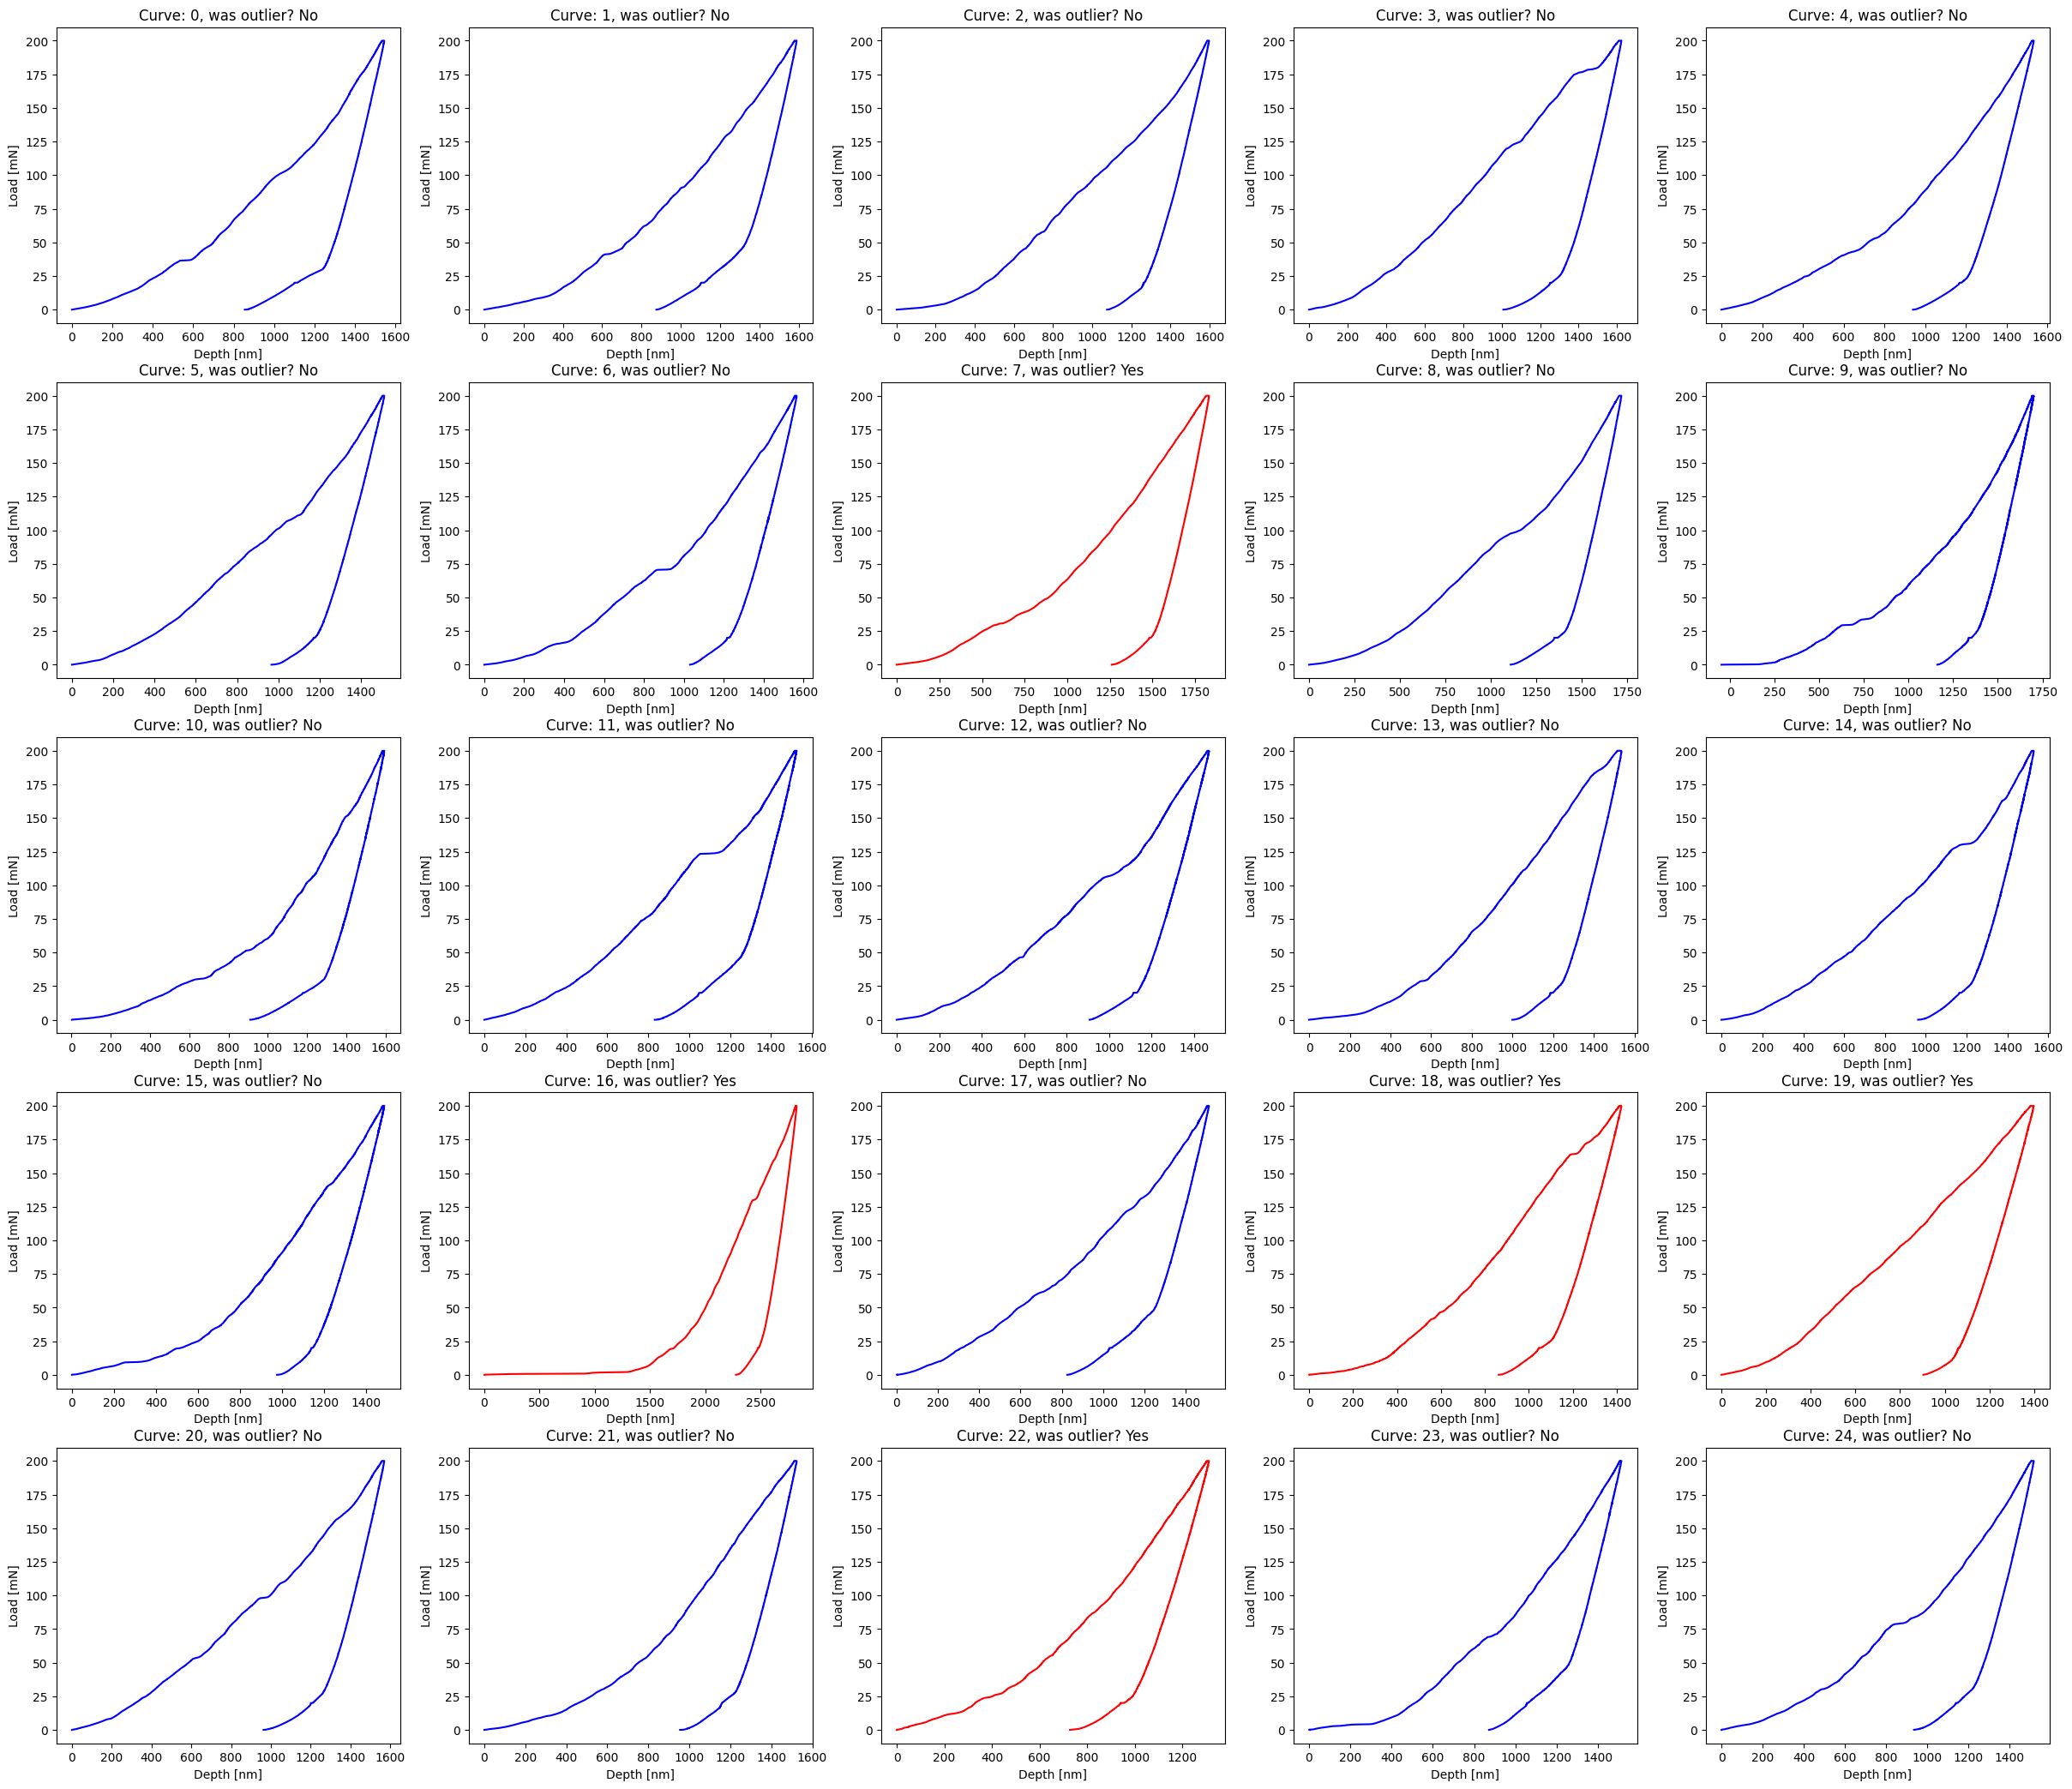

In [ ]:
fig, axis = plt.subplots(5,5,figsize=[30,26])
axis = axis.flatten()

# the following section is added to allow user input of the required load for analysis.

notyet = 0

while notyet == 0:
  print("Possible loads are 10, 50, 100, 200")
  variable_input = input("Please enter a load: ")
  chosen_load = int(variable_input)
  if chosen_load == load[0] or chosen_load == load[1] or chosen_load == load[2] or chosen_load == load[3]:
      print("Input is an acceptable value.")
      print("Input number is: ", chosen_load)
      notyet = 1
  else:
      print("This is not a valid load. Please enter a valid number")



chosen_curve = "curve_" + str(chosen_load)
chosen_results = "results_" + str(chosen_load)

for i in range(len(locals()[chosen_results])):
  curva = extract_curve(i,locals()[chosen_curve])
  x = curva.loc[:,"Depth [nm]"]
  y = curva.loc[:,"Load [mN]"]

  check = locals()[chosen_results].loc[i,'Outliers?']
  title = "Curve: " + str(i) + ", was outlier? " + check

  colorplot = 'blue'
  if check == "Yes":
    colorplot = 'red'

  axis[i].plot(x, y, color = colorplot)

  axis[i].set_title(title)
  axis[i].set_xlabel("Depth [nm]")
  axis[i].set_ylabel("Load [mN]")



We calculate the moving mean to avoid possible issues when we calculate the derivative of the loading curve.

In [ ]:
def calculate_movingmean(curva, chosen_load):
  '''
  Function to calculare the moving mean of a specific curve.
  INPUT = curva, the chosen curve, and chosen_load, the indentation load used to obtain this curve
  OUTPUT = curvamean, the moving mean values obtained for this curve
  '''
  curvamean = curva["Load [mN]"]
  # the rolling mean requires an interval to calculate the value itself
  # we change the interval based on loads due to the different scale of curves that can be obtained
  interval = 100
  if chosen_load == 10:
    interval = 20
  curvamean= curvamean.rolling(interval).mean()
  curvamean = curvamean.to_frame()
  curvamean = curvamean.join(curva["Depth [nm]"])
  curvamean.dropna(inplace=True)
  return curvamean

We calculate the derivative of each loading curve, based on the moving mean values of y. Since the pop-in occurs during the loading process, we disregard the unloading part of the curve.

We will highlight the curves that display pop-ins, based on a set threshold for the derivative of the curves.

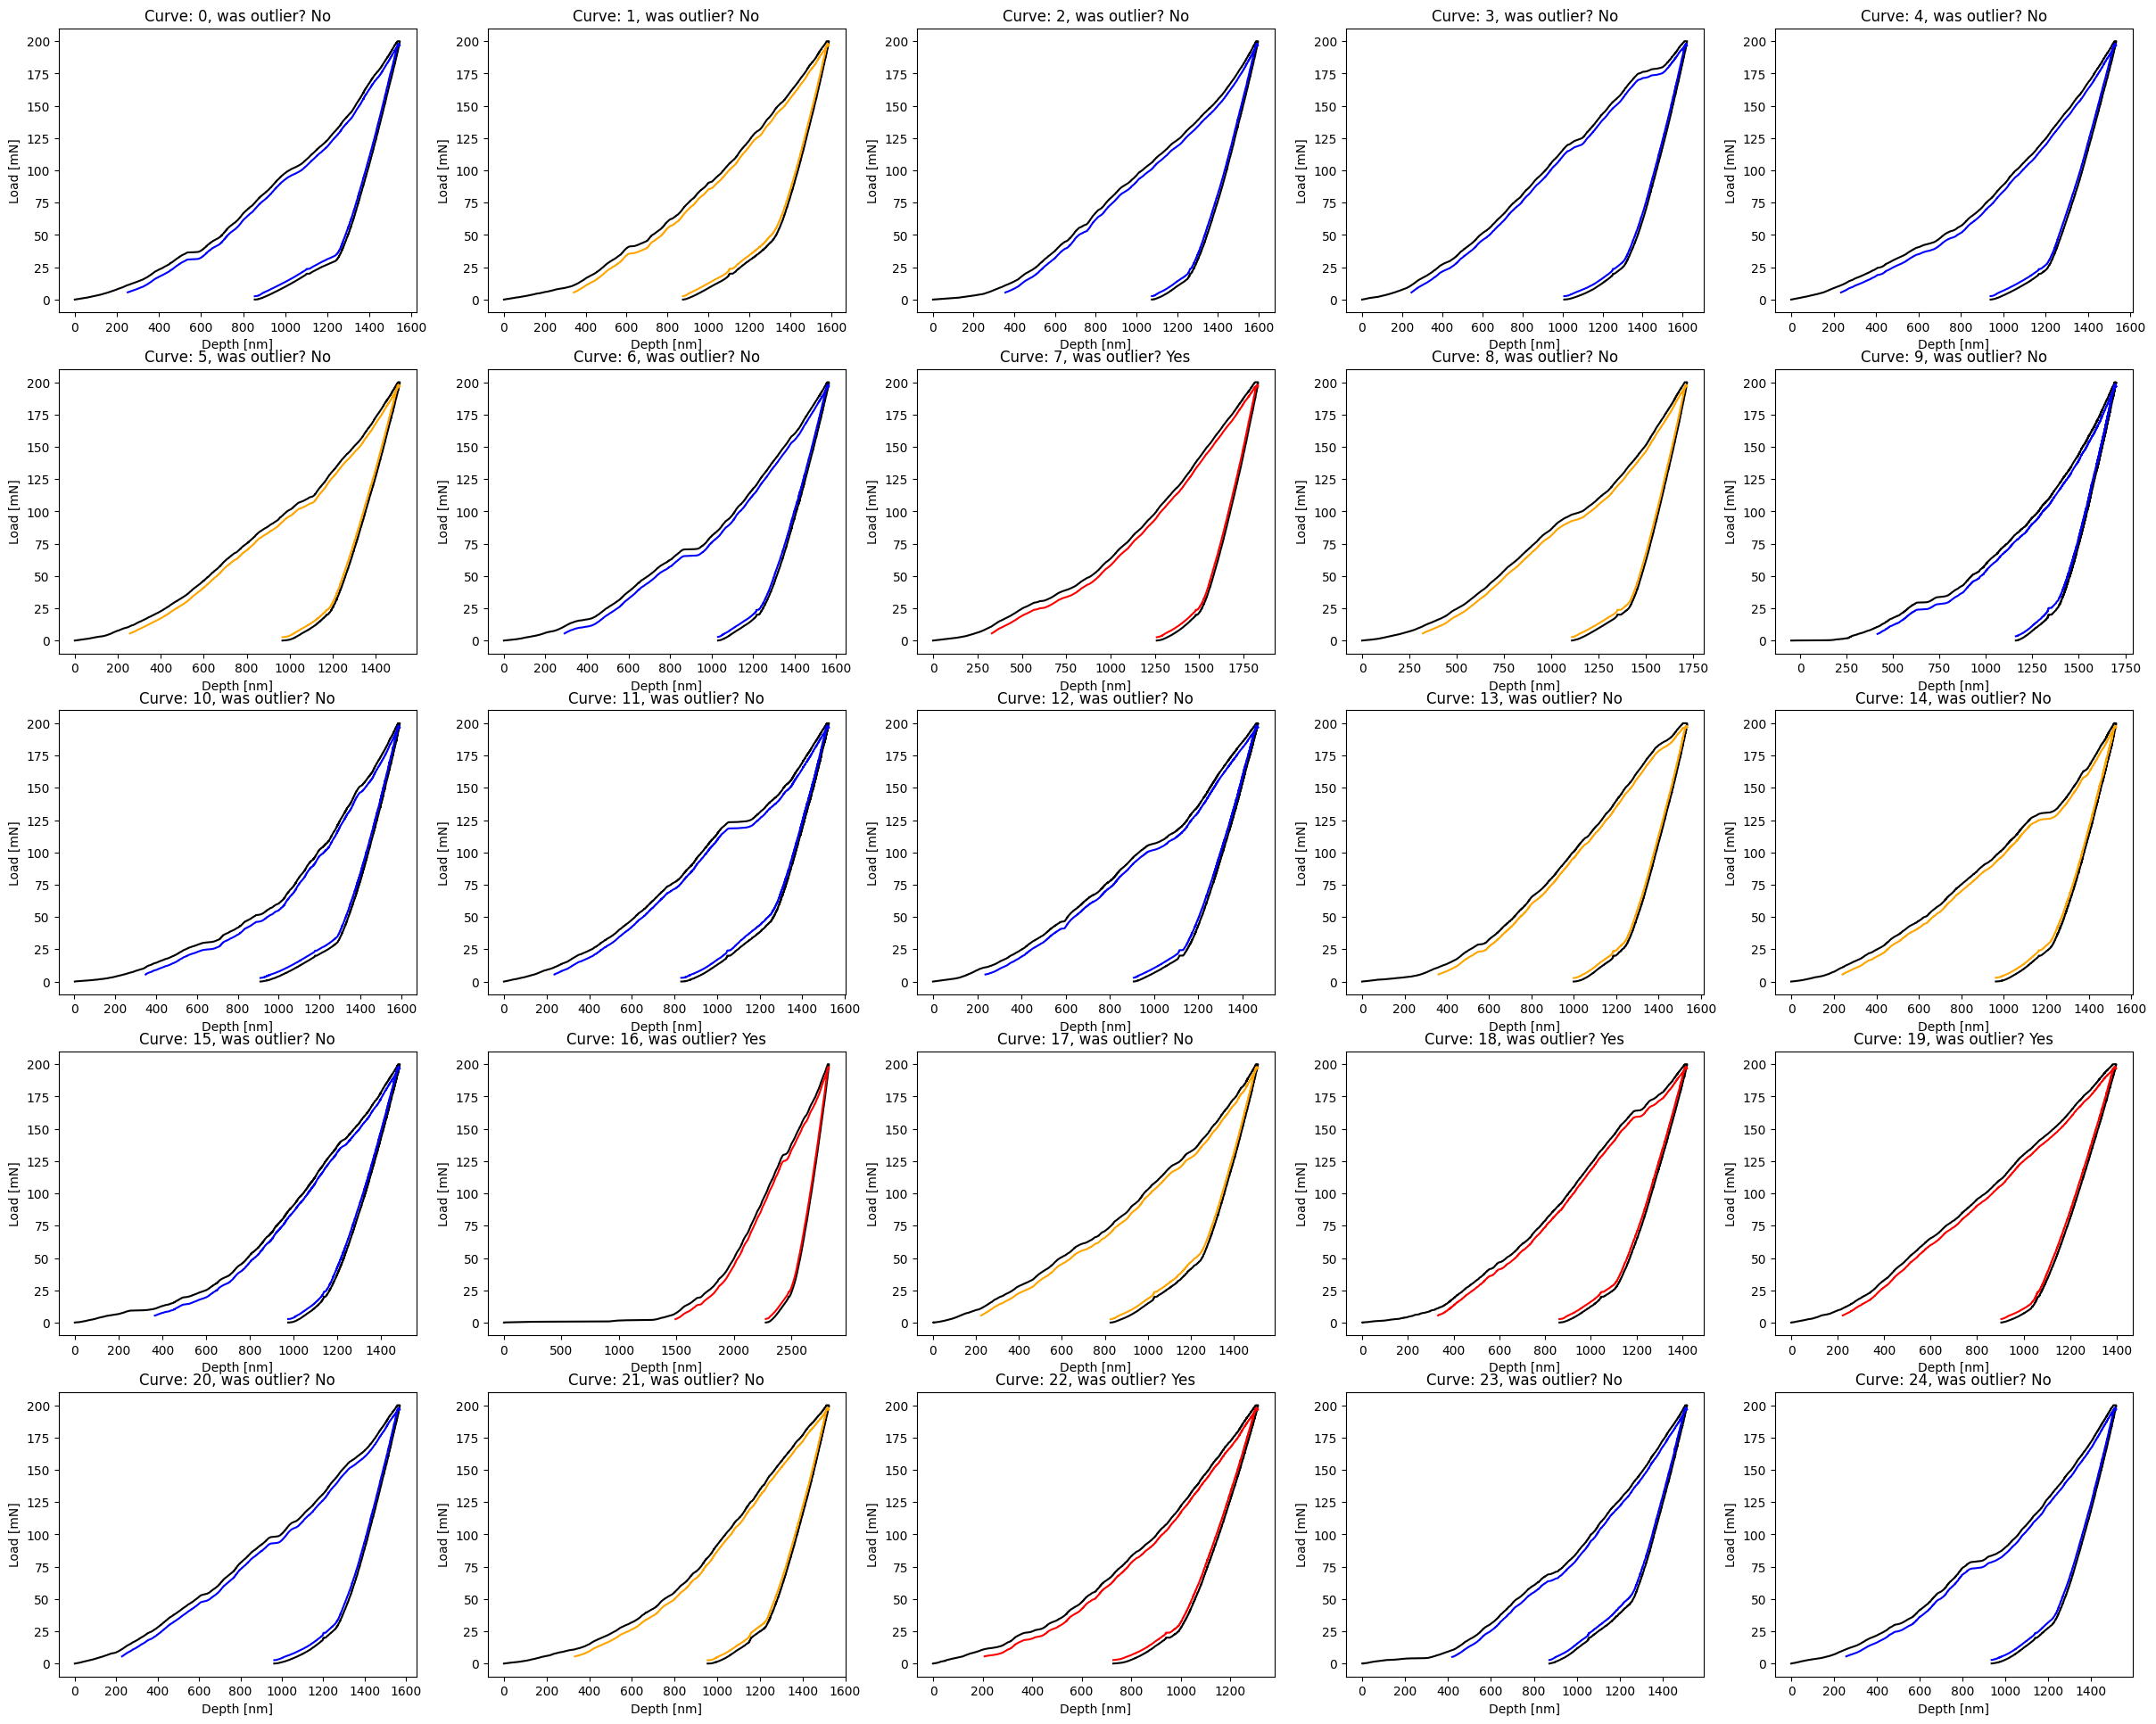

In [ ]:
# we initialize a plot, so we will be able to see all the boxplots highlighting the outliers

fig, axis = plt.subplots(5,5,figsize=[30,24])
axis = axis.flatten()

chosen_curve = "curve_" + str(chosen_load)
chosen_results = "results_" + str(chosen_load)

for i in range(len(locals()[chosen_results])):
  curva = extract_curve(i,locals()[chosen_curve])
  curvamean = calculate_movingmean(curva,chosen_load)
  indice = curvamean.index[curvamean["Load [mN]"] == max(curvamean["Load [mN]"])].values.item(0) - 10
  # we remove the last 10 entries before the highest load, in order to avoid mistakes associated to the flat part of the curve
  # that is always present at the end of the loading section.
  # due to numerical oscillations, the highest load may happen after the start of this "holding" phase


  x = curva.loc[:,"Depth [nm]"]
  y = curva.loc[:,"Load [mN]"]

  xm = curvamean.loc[:,"Depth [nm]"]
  ym = curvamean.loc[:,"Load [mN]"]

  der = np.gradient(curvamean.loc[0:indice,"Load [mN]"],curvamean.loc[0:indice,"Depth [nm]"])
  #der = pd.DataFrame(der)

  check = locals()[chosen_results].loc[i,'Outliers?']
  title = "Curve: " + str(i) + ", was outlier? " + check

  colorplot = 'blue'
  if check == "Yes":
    colorplot = 'red'

  # the following threshold was arbitrarily chosen
  if (der < -400).any() or (der > 400).any():
    colorplot = 'orange'

  axis[i].plot(x, y, color = 'k', label = 'Original Curve')
  axis[i].plot(xm, ym, color=colorplot, label = 'Moving Mean')
  #axis[i].plot(xm, der, color=colorplot, label = 'Derivate Function')

  if locals()[chosen_results].loc[i, 'Outliers?'] == 'No' and colorplot == 'orange':
    locals()[chosen_results].loc[i, 'Outliers?'] = 'Yes'

  axis[i].set_title(title)
  axis[i].set_xlabel("Depth [nm]")
  axis[i].set_ylabel("Load [mN]")

## 3. Finalization
Now that we have selected all of these outliers, we visualize the new boxplots and print the values of elastic moduli and hardness obtained from the indentations.

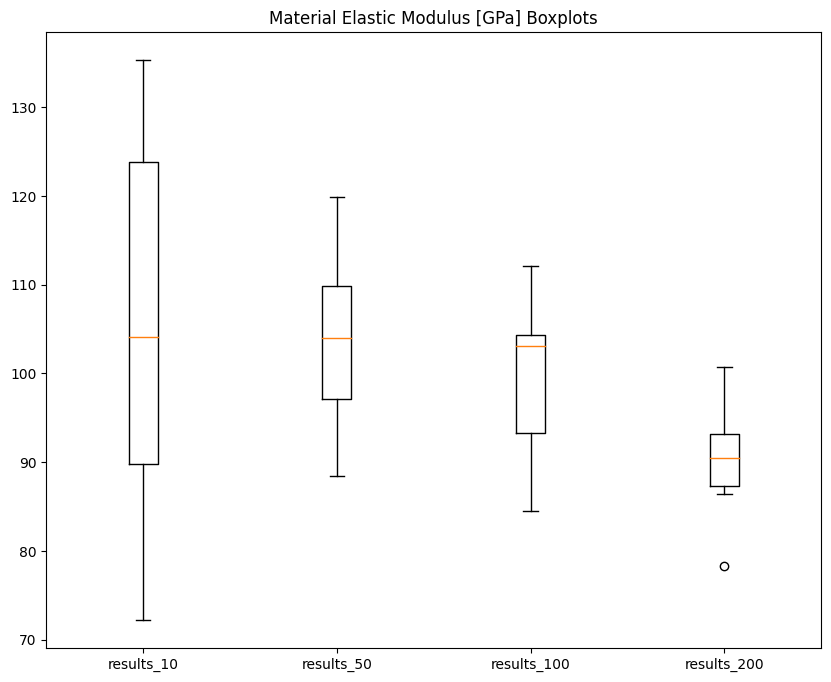

In [ ]:
n = 3; # this corresponds to choosing to perform our analysis on the material elastic modulus

# we initialize a plot, so we will be able to see all the boxplots highlighting the outliers

fig = plt.subplots(1,1,figsize=[10,8])
ax = plt.subplot(111)
tick_labels = []

for i in range(4):
  #plt.sca(axes[i])

  varname = "results_" + str(load[i])
  tick_labels.append(varname)
  temp = locals()[varname]

  # we want to plot all the boxplots in the same plot, so that they share the vertical scalebar
  ax.boxplot(temp.loc[temp['Outliers?'] == 'No'].iloc[:,n],positions=[i])

plt.title("Material Elastic Modulus [GPa] Boxplots")
ax.set_xticklabels(tick_labels)
plt.show()

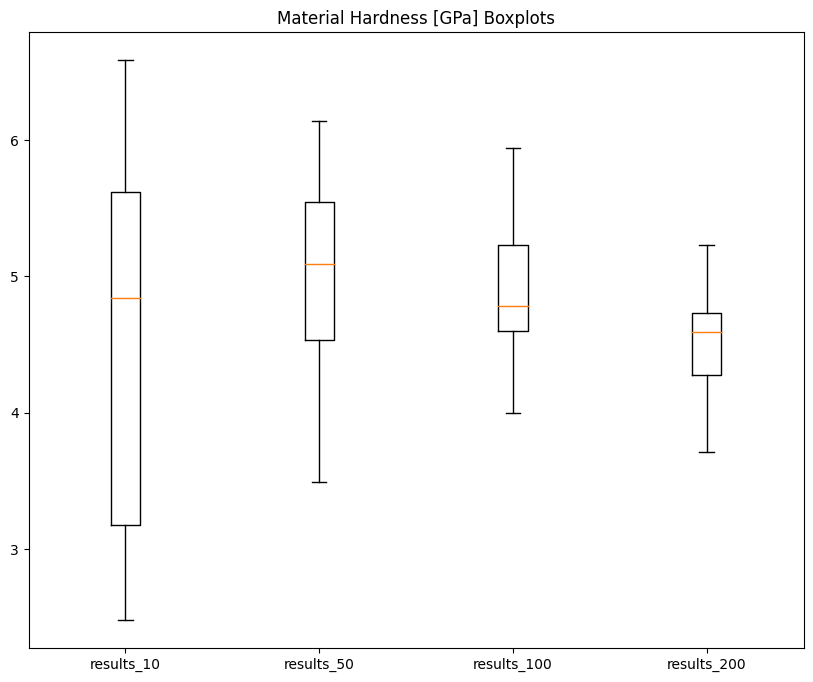

In [ ]:
n = 1; # this corresponds to choosing to perform our analysis on the hardness

# we initialize a plot, so we will be able to see all the boxplots highlighting the outliers

fig = plt.subplots(1,1,figsize=[10,8])
ax = plt.subplot(111)
tick_labels = []

for i in range(4):

  varname = "results_" + str(load[i])
  tick_labels.append(varname)
  temp = locals()[varname]
  z = np.abs(stats.zscore(temp.iloc[:,n]))

  threshold = 1
  outliers = temp[z > threshold]

  # we want to plot all the boxplots in the same plot, so that they share the vertical scalebar
  ax.boxplot(temp.loc[temp['Outliers?'] == 'No'].iloc[:,n],positions=[i])

plt.title("Material Hardness [GPa] Boxplots")
ax.set_xticklabels(tick_labels)
plt.show()

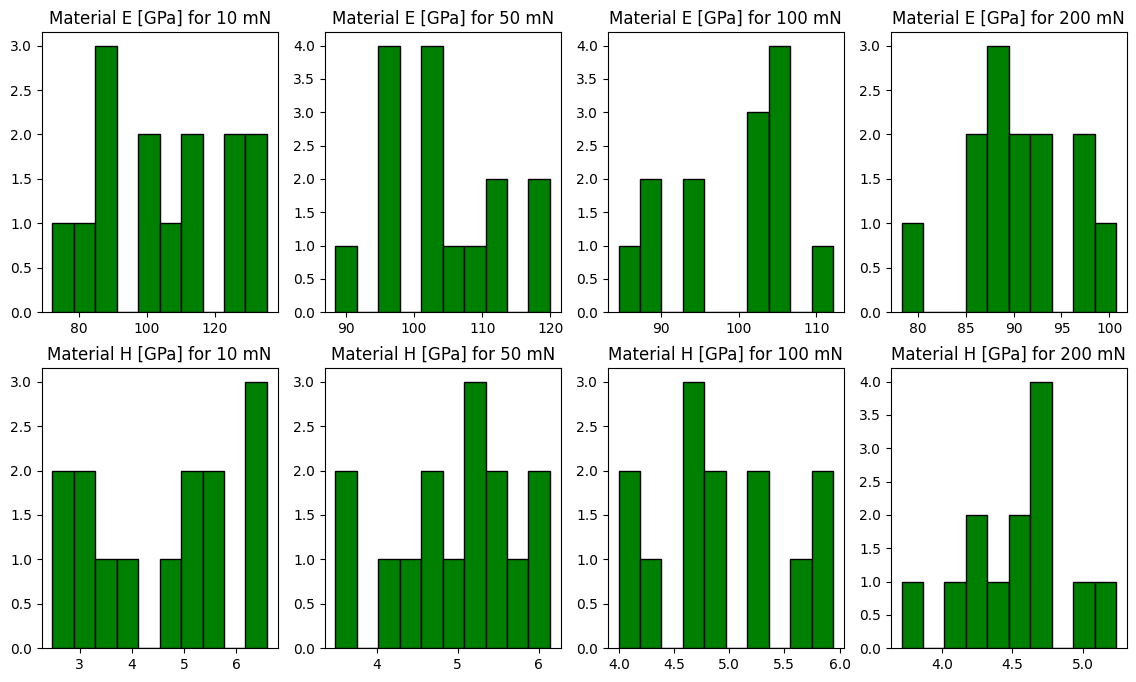

In [ ]:
all_loads_updated = pd.DataFrame([])

fig, axes = plt.subplots(2,4,figsize=[14,8])
axes = axes.flatten()

for i in range(4):

  varname = "results_" + str(load[i])
  temp = locals()[varname]
  temp_filtered = temp.loc[temp['Outliers?'] == 'No']
  # we only consider the rows of indentations that are not marked as outliers

  plt.sca(axes[i])
  n = 3;
  shap = shapiro(temp_filtered.iloc[:,n])

  # the assumed "norm" is a normal data distribution
  nonnorm = "green"
  check = "Yes"
  summary_value = temp_filtered.iloc[:,n].mean()
  deviation = temp_filtered.iloc[:,n].std()

  if shap[1] < 0.05:
    # if the pvalue is smaller than 0.05 we can reject the null hypothesis
    # therefore we have evidence that the distribution is not normal
    # we will color the corresponding histograms in red
    # and calculate medians and interquartile ranges
    nonnorm = "red"
    check = "No"
    summary_value = temp_filtered.iloc[:,n].median()
    quartiles = temp_filtered.iloc[:,n].quantile([0.25, 0.75])
    deviation = quartiles[0.75] - quartiles[0.25]

  # we store the values obtained for the Elastic Modulus inside a temporary dataframe
  temporaryE_updated = pd.DataFrame({"Indentation Load": str(load[i]),
                          "E Normal?": check,
                          "E Normality Pvalue" : shap[1],
                          "E Mean / Median" : summary_value,
                          "E StDev / IntRg" : deviation}, index = [0])

  plt.hist(temp_filtered.iloc[:,n], color = nonnorm, ec="black")
  plt.title("Material E [GPa] for " + str(load[i]) + " mN")

  # now starts the section relative to the hardness
  plt.sca(axes[i+4])
  n = 1;
  shap = shapiro(temp_filtered.iloc[:,n])


  nonnorm = "green"
  check = "Yes"
  summary_value = temp_filtered.iloc[:,n].mean()
  deviation = temp_filtered.iloc[:,n].std()

  if shap[1] < 0.05:
    # if the pvalue is smaller than 0.05 we can reject the null hypothesis
    # therefore we have evidence that the distribution is not normal
    # we will color the corresponding histograms in red
    # and calculate medians and interquartile ranges
    nonnorm = "red"
    check = "No"
    summary_value = temp_filtered.iloc[:,n].median()
    quartiles = temp_filtered.iloc[:,n].quantile([0.25, 0.75])
    deviation = quartiles[0.75] - quartiles[0.25]


  temporaryH_updated = pd.DataFrame({"H Normal?": check,
                          "H Normality Pvalue" : shap[1],
                          "H Mean / Median" : summary_value,
                          "H StDev / IntRg" : deviation}, index = [0])

  plt.hist(temp_filtered.iloc[:,n], color = nonnorm, ec="black")
  plt.title("Material H [GPa] for " + str(load[i]) + " mN")

  # we concatenate the two dataframes for the elastic modulus and hardness along the columns
  temporary_updated = pd.concat([temporaryE_updated, temporaryH_updated], axis = 1)

  # and store all the obtained values in the dataframe "all_loads", where each row will correspond to a different indentation load
  all_loads_updated = pd.concat([all_loads_updated, temporary_updated], ignore_index = True, axis = 0)


plt.show()

In [ ]:
print(all_loads)
print(all_loads_updated)

  Indentation Load E Normal?  E Normality Pvalue  E Mean / Median  \
0               10       Yes            0.471224       104.603335   
1               50       Yes            0.873129       102.256922   
2              100       Yes            0.410129        98.373536   
3              200       Yes            0.609015        91.104267   

   E StDev / IntRg H Normal?  H Normality Pvalue  H Mean / Median  \
0        19.690078       Yes            0.119449         4.445879   
1         8.747546       Yes            0.429159         4.782048   
2         8.068627       Yes            0.647452         4.821535   
3         5.936908       Yes            0.241448         4.520909   

   H StDev / IntRg  
0         1.495386  
1         0.847356  
2         0.657806  
3         0.407086  
  Indentation Load E Normal?  E Normality Pvalue  E Mean / Median  \
0               10       Yes            0.596991       105.726665   
1               50       Yes            0.922395       104.122603